<a href="https://colab.research.google.com/github/vinaykotadiya/ev-adoption-forecast/blob/main/ZEV_Forcasting_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Link:https://drive.google.com/file/d/1Lji1x-YhB3PcnJO4hx_nFwMTii5nkvne/view?usp=sharing**

In [ ]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# **DATA CLEANING**

In [ ]:
# read the uploaded file
df = pd.read_csv('df_VEH0120_UK.csv')

# show basic info
print("Rows and Columns:", df.shape)
df.head()

Rows and Columns: (208751, 49)


,BodyType,Make,GenModel,Model,Fuel,LicenceStatus,2025Q1,2024Q4,2024Q3,2024Q2,...,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,2015Q1,2014Q4,2014Q3
0,Cars,ABARTH,ABARTH 124,124 GT MULTIAIR,Petrol,Licensed,15,14,15,16,...,0,0,0,0,0,0,0,0,0,0
1,Cars,ABARTH,ABARTH 124,124 GT MULTIAIR,Petrol,SORN,4,5,4,3,...,0,0,0,0,0,0,0,0,0,0
2,Cars,ABARTH,ABARTH 124,124 GT MULTIAIR AUTO,Petrol,Licensed,26,25,27,25,...,0,0,0,0,0,0,0,0,0,0
3,Cars,ABARTH,ABARTH 124,124 GT MULTIAIR AUTO,Petrol,SORN,3,4,2,2,...,0,0,0,0,0,0,0,0,0,0
4,Cars,ABARTH,ABARTH SPIDER,124 SPIDER MULTIAIR,Petrol,Licensed,973,960,978,978,...,155,100,0,0,0,0,0,0,0,0


In [ ]:
# check for missing values and duplicates
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Missing values per column:
 BodyType         0
Make             0
GenModel         2
Model            0
Fuel             0
LicenceStatus    0
2025Q1           0
2024Q4           0
2024Q3           0
2024Q2           0
2024Q1           0
2023Q4           0
2023Q3           0
2023Q2           0
2023Q1           0
2022Q4           0
2022Q3           0
2022Q2           0
2022Q1           0
2021Q4           0
2021Q3           0
2021Q2           0
2021Q1           0
2020Q4           0
2020Q3           0
2020Q2           0
2020Q1           0
2019Q4           0
2019Q3           0
2019Q2           0
2019Q1           0
2018Q4           0
2018Q3           0
2018Q2           0
2018Q1           0
2017Q4           0
2017Q3           0
2017Q2           0
2017Q1           0
2016Q4           0
2016Q3           0
2016Q2           0
2016Q1           0
2015Q4           0
2015Q3           0
2015Q2           0
2015Q1           0
2014Q4           0
2014Q3           0
dtype: int64

Duplicate rows: 0


In [ ]:
# remove duplicate and empty rows
df.drop_duplicates(inplace=True)
df.dropna(how='all', inplace=True)

In [ ]:
# clean text data (remove spaces and fix case)
df['BodyType'] = df['BodyType'].str.strip().str.title()
df['Fuel'] = df['Fuel'].str.strip().str.title()
df['LicenceStatus'] = df['LicenceStatus'].str.strip().str.title()

In [ ]:
# show unique values to understand data categories
print("\nDifferent BodyType:", df['BodyType'].unique())
print("\nDifferent Fuel:", df['Fuel'].unique())
print("\nDifferent LicenceStatus:", df['LicenceStatus'].unique())


Different BodyType: ['Cars' 'Heavy Goods Vehicles' 'Light Goods Vehicles' 'Other Vehicles'
 'Motorcycles' 'Buses And Coaches']

Different Fuel: ['Petrol' 'Battery Electric' 'Gas' 'Diesel' 'Hybrid Electric (Petrol)'
 'Plug-In Hybrid Electric (Petrol)' 'Hybrid Electric (Diesel)'
 'Plug-In Hybrid Electric (Diesel)' 'Other Fuel Types'
 'Range Extended Electric' 'Fuel Cell Electric']

Different LicenceStatus: ['Licensed' 'Sorn']


In [ ]:
# filter only licensed fully electric cars
ev_types = ['Battery Electric', 'Fuel Cell Electric', 'Range Extended Electric']

df_cars = df[
    (df['BodyType'] == 'Cars') &
    (df['Fuel'].isin(ev_types)) &
    (df['LicenceStatus'] == 'Licensed')
].reset_index(drop=True)

In [ ]:
# preview the filtered dataset
print(df_cars.shape)
df_cars.head()

(1359, 49)


,BodyType,Make,GenModel,Model,Fuel,LicenceStatus,2025Q1,2024Q4,2024Q3,2024Q2,...,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,2015Q1,2014Q4,2014Q3
0,Cars,ABARTH,ABARTH 500,500E,Battery Electric,Licensed,232,192,139,68,...,0,0,0,0,0,0,0,0,0,0
1,Cars,ABARTH,ABARTH 500,500E SCORPIONISSIMA,Battery Electric,Licensed,133,130,129,111,...,0,0,0,0,0,0,0,0,0,0
2,Cars,ABARTH,ABARTH 500,500E TURISMO,Battery Electric,Licensed,182,177,164,140,...,0,0,0,0,0,0,0,0,0,0
3,Cars,ABARTH,ABARTH 600E,600E,Battery Electric,Licensed,30,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cars,ABARTH,ABARTH 600E,600E SCORPIONISSIMA,Battery Electric,Licensed,26,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print("\nDifferent BodyType:", df_cars['BodyType'].unique())
print("\nDifferent Fuel:", df_cars['Fuel'].unique())
print("\nDifferent LicenceStatus:", df_cars['LicenceStatus'].unique())


Different BodyType: ['Cars']

Different Fuel: ['Battery Electric' 'Range Extended Electric' 'Fuel Cell Electric']

Different LicenceStatus: ['Licensed']


In [ ]:
# save clean dataset
df_cars.to_csv('ev_cars_uk.csv', index=False)

In [ ]:
# read the cleaned EV cars data
data = pd.read_csv('ev_cars_uk.csv')
print("Rows and Columns:", data.shape)
data.head()

Rows and Columns: (1359, 49)


,BodyType,Make,GenModel,Model,Fuel,LicenceStatus,2025Q1,2024Q4,2024Q3,2024Q2,...,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,2015Q1,2014Q4,2014Q3
0,Cars,ABARTH,ABARTH 500,500E,Battery Electric,Licensed,232,192,139,68,...,0,0,0,0,0,0,0,0,0,0
1,Cars,ABARTH,ABARTH 500,500E SCORPIONISSIMA,Battery Electric,Licensed,133,130,129,111,...,0,0,0,0,0,0,0,0,0,0
2,Cars,ABARTH,ABARTH 500,500E TURISMO,Battery Electric,Licensed,182,177,164,140,...,0,0,0,0,0,0,0,0,0,0
3,Cars,ABARTH,ABARTH 600E,600E,Battery Electric,Licensed,30,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cars,ABARTH,ABARTH 600E,600E SCORPIONISSIMA,Battery Electric,Licensed,26,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **EDA**

In [ ]:
# find all quarterly columns (like 2014Q3, 2014Q4, etc.)
quarter_columns = [col for col in data.columns if re.match(r'^\d{4}Q[1-4]$', col)]
print("Total quarters found:", len(quarter_columns))
print("Example columns:", quarter_columns)

Total quarters found: 43
Example columns: ['2025Q1', '2024Q4', '2024Q3', '2024Q2', '2024Q1', '2023Q4', '2023Q3', '2023Q2', '2023Q1', '2022Q4', '2022Q3', '2022Q2', '2022Q1', '2021Q4', '2021Q3', '2021Q2', '2021Q1', '2020Q4', '2020Q3', '2020Q2', '2020Q1', '2019Q4', '2019Q3', '2019Q2', '2019Q1', '2018Q4', '2018Q3', '2018Q2', '2018Q1', '2017Q4', '2017Q3', '2017Q2', '2017Q1', '2016Q4', '2016Q3', '2016Q2', '2016Q1', '2015Q4', '2015Q3', '2015Q2', '2015Q1', '2014Q4', '2014Q3']


In [ ]:
# make a time series with total EVs per quarter
trend_data = data[quarter_columns].sum().reset_index()
trend_data.columns = ['Quarter', 'Registered_Cars']

# convert quarter to proper date (end of quarter)
trend_data['Quarter_End'] = pd.PeriodIndex(trend_data['Quarter'], freq='Q').to_timestamp(how='end')
trend_data = trend_data.sort_values('Quarter_End').set_index('Quarter_End')


In [ ]:
# save this dataset for forecasting later
trend_data[['Registered_Cars']].to_csv('ev_trend.csv')
trend_data.head()

,Quarter,Registered_Cars
Quarter_End,,
2014-09-30 23:59:59.999999999,2014Q3,12392
2014-12-31 23:59:59.999999999,2014Q4,14571
2015-03-31 23:59:59.999999999,2015Q1,17267
2015-06-30 23:59:59.999999999,2015Q2,19291
2015-09-30 23:59:59.999999999,2015Q3,21683


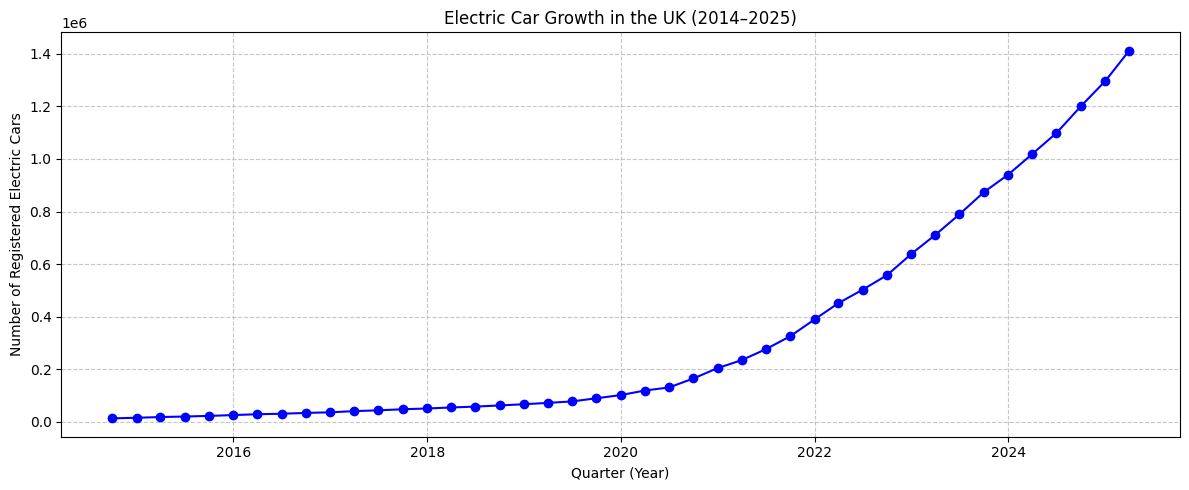

In [ ]:
# make a line chart to show how electric cars increased over time
plt.figure(figsize=(12,5))

# plot total registered electric cars per quarter
plt.plot(trend_data.index, trend_data['Registered_Cars'], marker='o', color='blue')

# add title and axis labels
plt.title('Electric Car Growth in the UK (2014–2025)')
plt.xlabel('Quarter (Year)')     # time along the X-axis
plt.ylabel('Number of Registered Electric Cars')   # total EVs along Y-axis

# add light grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# adjust layout
plt.tight_layout()

# display the chart
plt.show()

In [ ]:
# calculate quarter-to-quarter percentage growth
trend_data['Growth_Rate'] = trend_data['Registered_Cars'].pct_change() * 100

# calculate year-over-year percentage growth (compare to same quarter last year)
trend_data['YoY_Growth'] = trend_data['Registered_Cars'].pct_change(periods=4) * 100

# check that columns are created correctly
print(trend_data[['Registered_Cars', 'Growth_Rate', 'YoY_Growth']].head(10))

                               Registered_Cars  Growth_Rate  YoY_Growth
Quarter_End                                                            
2014-09-30 23:59:59.999999999            12392          NaN         NaN
2014-12-31 23:59:59.999999999            14571    17.583925         NaN
2015-03-31 23:59:59.999999999            17267    18.502505         NaN
2015-06-30 23:59:59.999999999            19291    11.721781         NaN
2015-09-30 23:59:59.999999999            21683    12.399565   74.975791
2015-12-31 23:59:59.999999999            24818    14.458331   70.324617
2016-03-31 23:59:59.999999999            28029    12.938190   62.326982
2016-06-30 23:59:59.999999999            29891     6.643120   54.947903
2016-09-30 23:59:59.999999999            33054    10.581780   52.442005
2016-12-31 23:59:59.999999999            35349     6.943184   42.432912


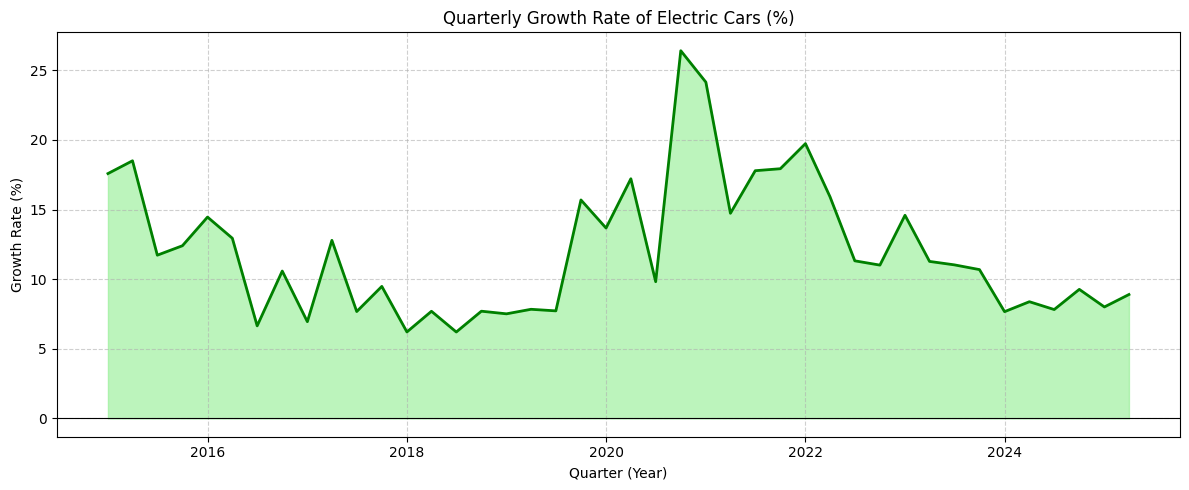

In [ ]:
# area chart to show quarterly growth percentage of electric cars
plt.figure(figsize=(12,5))

# fill the area under the growth rate line with light green color
plt.fill_between(trend_data.index, trend_data['Growth_Rate'], color='lightgreen', alpha=0.6)

# draw the growth rate line on top of the area
plt.plot(trend_data.index, trend_data['Growth_Rate'], color='green', linewidth=2)

# add title and axis labels
plt.title('Quarterly Growth Rate of Electric Cars (%)')
plt.xlabel('Quarter (Year)')        # shows time
plt.ylabel('Growth Rate (%)')       # shows how fast EV adoption is growing

# add light grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# add a horizontal line at 0 to separate positive and negative growth
plt.axhline(0, color='black', linewidth=0.8)

# adjust spacing so labels
plt.tight_layout()

# display the final chart
plt.show()

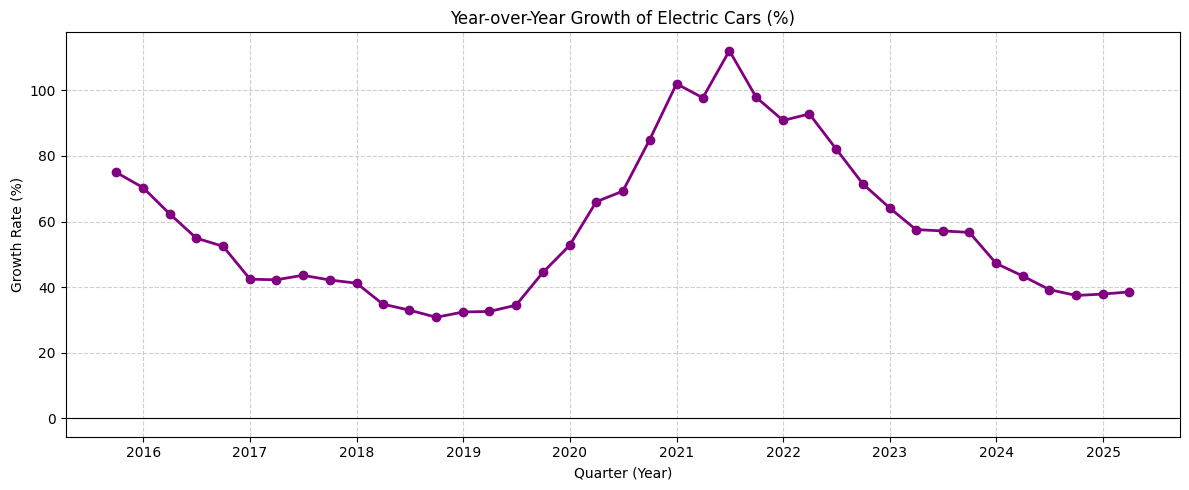

In [ ]:
# make a line chart to show the yearly growth rate of electric cars
plt.figure(figsize=(12,5))

# plot the YoY growth line with purple color and dots on each point
plt.plot(trend_data.index, trend_data['YoY_Growth'], color='purple', linewidth=2, marker='o')

# add a clear title and axis labels
plt.title('Year-over-Year Growth of Electric Cars (%)')
plt.xlabel('Quarter (Year)')     # X-axis shows time (quarters)
plt.ylabel('Growth Rate (%)')    # Y-axis shows yearly growth percentage

# add light grid lines to make the chart easier to read
plt.grid(True, linestyle='--', alpha=0.6)

# add a horizontal line at 0% to show the baseline
plt.axhline(0, color='black', linewidth=0.8)

# fix spacing so titles and labels are not cut off
plt.tight_layout()

# show the final chart
plt.show()


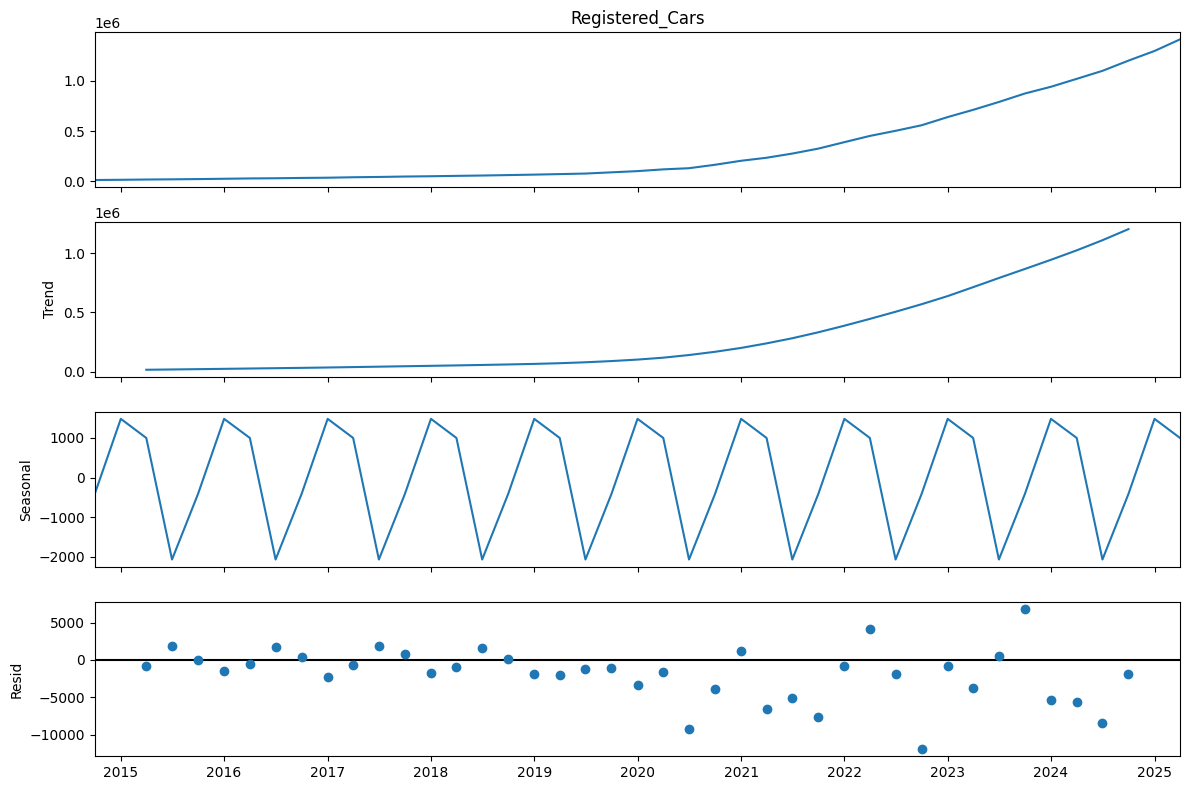

In [ ]:
# check if we have enough quarters to see seasonality
if len(trend_data) >= 8:
    # break the data into 3 parts: trend, seasonal pattern, and random noise
    result = seasonal_decompose(trend_data['Registered_Cars'], model='additive', period=4)

    # plot all three parts together
    fig = result.plot()
    fig.set_size_inches(12,8)

    # adjust spacing
    plt.tight_layout()

    # show the final chart
    plt.show()
else:
    print("Not enough data points for seasonal analysis.")

#**PreProcessing**

In [ ]:
# check if any missing values are present
print("\nMissing values per column:\n", trend_data.isnull().sum())


Missing values per column:
 Quarter            0
Registered_Cars    0
Growth_Rate        1
YoY_Growth         4
dtype: int64


In [ ]:
# replace missing growth values with 0
trend_data[['Growth_Rate', 'YoY_Growth']] = trend_data[['Growth_Rate', 'YoY_Growth']].fillna(0)

# check again
print("\nAfter handling missing values:")
print(trend_data.isnull().sum())


After handling missing values:
Quarter            0
Registered_Cars    0
Growth_Rate        0
YoY_Growth         0
dtype: int64


In [ ]:
# ensure datetime index
trend_data.index = pd.to_datetime(trend_data.index)

In [ ]:
# train/test split (last 10 quarters as test)
n_test = 10
train = trend_data.iloc[:-n_test].copy()
test  = trend_data.iloc[-n_test:].copy()
print("Train shape:", train.shape, "Test shape:", test.shape)

Train shape: (33, 4) Test shape: (10, 4)


In [ ]:
# Check if data is stationary

series = train['Registered_Cars'].dropna()

adf_stat, p_value = adfuller(series)[:2]
print(f"ADF Statistic = {adf_stat:.4f} | p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Data is stationary.")
else:
    print(" Data is non-stationary.")

ADF Statistic = 1.8674 | p-value = 0.9985
 Data is non-stationary.


#**ARIMA**


In [ ]:
# Fit ARIMA model
order = (1,1,1)  # (p, d, q)

arima_model = ARIMA(train['Registered_Cars'], order=order).fit()

In [ ]:
# Forecast next quarters & evaluate
n_steps = len(test)
forecast = arima_model.forecast(steps=n_steps)
forecast = np.asarray(forecast)
forecast_series = pd.Series(forecast, index=test.index)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Registered_Cars'], forecast_series))
print("RMSE:", rmse)

RMSE: 161922.17266553812


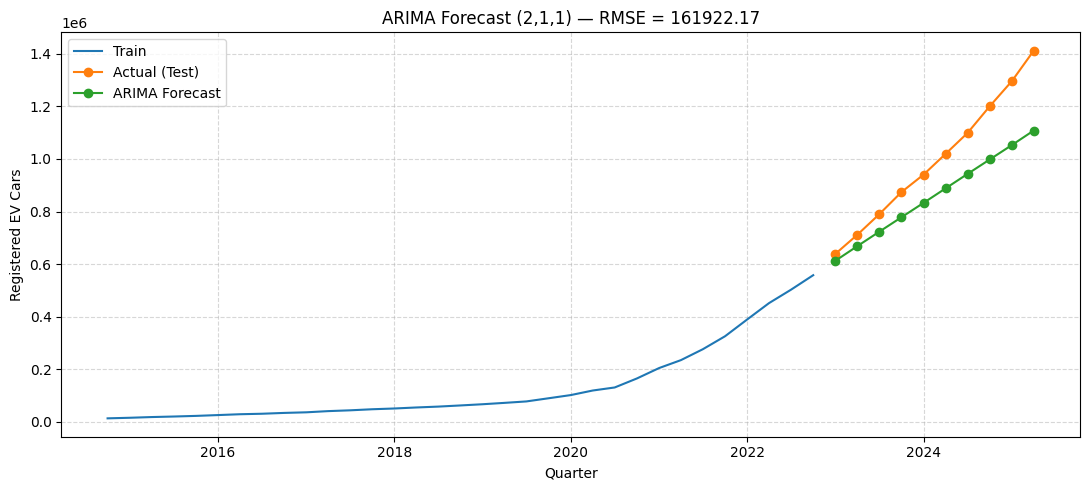

In [ ]:
# plot results
plt.figure(figsize=(11,5))
plt.plot(train.index, train['Registered_Cars'], label='Train')
plt.plot(test.index, test['Registered_Cars'], marker='o', label='Actual (Test)')
plt.plot(forecast_series.index, forecast_series, marker='o', label='ARIMA Forecast')
plt.title(f'ARIMA Forecast (2,1,1) — RMSE = {rmse:.2f}')
plt.xlabel('Quarter'); plt.ylabel('Registered EV Cars')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout();
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(test['Registered_Cars'], forecast_series) * 100
accuracy = 100 - mape
print(f"ARIMA Accuracy: {accuracy:.2f}%")

ARIMA Accuracy: 87.47%


In [ ]:
# Hyperparameter Tuning (Grid Search)
# define parameter ranges to test
p_values = [0, 1, 2]
d_values = [1]          # one differencing needed for trend
q_values = [0, 1, 2]

# length of test data
h = len(test)

results = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)

            # fit model with this parameter combination
            model = ARIMA(train['Registered_Cars'], order=order).fit()

            # forecast and compute RMSE
            fc = model.forecast(steps=h)
            fc = pd.Series(fc, index=test.index)
            rmse = np.sqrt(mean_squared_error(test['Registered_Cars'], fc))

            # store results
            results.append([p, d, q, rmse])
            print(f"ARIMA{order} -> RMSE = {rmse:.2f}")

# convert results to dataframe
results_df = pd.DataFrame(results, columns=['p','d','q','rmse'])
results_df = results_df.sort_values('rmse').reset_index(drop=True)

# find best parameters
best_order = tuple(results_df.loc[0, ['p','d','q']])
best_rmse = results_df.loc[0, 'rmse']

print("\nBest ARIMA order:", best_order)
print("Best RMSE:", best_rmse)

# save tuning table
results_df.to_csv("arima_grid_results.csv", index=False)


ARIMA(0, 1, 0) -> RMSE = 502795.82
ARIMA(0, 1, 1) -> RMSE = 478897.49
ARIMA(0, 1, 2) -> RMSE = 458838.73
ARIMA(1, 1, 0) -> RMSE = 160871.57
ARIMA(1, 1, 1) -> RMSE = 161922.17
ARIMA(1, 1, 2) -> RMSE = 159489.98
ARIMA(2, 1, 0) -> RMSE = 161959.76
ARIMA(2, 1, 1) -> RMSE = 159455.77
ARIMA(2, 1, 2) -> RMSE = 160685.85

Best ARIMA order: (2.0, 1.0, 1.0)
Best RMSE: 159455.77293907147


RMSE: 159489.98177726558


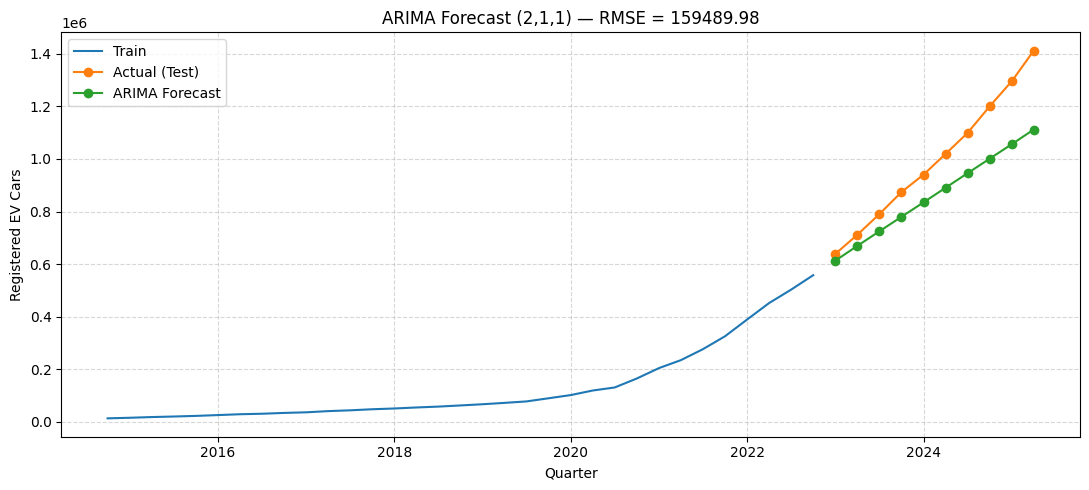

In [ ]:
# Fit ARIMA model
order = (1,1,2)  # (p, d, q)

arima_model = ARIMA(train['Registered_Cars'], order=order).fit()

# Forecast next quarters & evaluate
n_steps = len(test)
forecast = arima_model.forecast(steps=n_steps)
forecast = np.asarray(forecast)
forecast_series = pd.Series(forecast, index=test.index)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Registered_Cars'], forecast_series))
print("RMSE:", rmse)

# plot results
plt.figure(figsize=(11,5))
plt.plot(train.index, train['Registered_Cars'], label='Train')
plt.plot(test.index, test['Registered_Cars'], marker='o', label='Actual (Test)')
plt.plot(forecast_series.index, forecast_series, marker='o', label='ARIMA Forecast')
plt.title(f'ARIMA Forecast (2,1,1) — RMSE = {rmse:.2f}')
plt.xlabel('Quarter'); plt.ylabel('Registered EV Cars')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout();
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(test['Registered_Cars'], forecast_series) * 100
accuracy = 100 - mape
print(f"ARIMA Accuracy: {accuracy:.2f}%")

ARIMA Accuracy: 87.68%


#**Holt-Winter**

In [ ]:
# Fit Holt-Winters on training data
hw_model = ExponentialSmoothing(
    train['Registered_Cars'],
    trend='add',
    seasonal='add',
    seasonal_periods=4,
    initialization_method='estimated'
).fit(optimized=True)

# Forecast same horizon as test
hw_forecast = hw_model.forecast(steps=len(test))

# Evaluate with RMSE
rmse_hw = np.sqrt(mean_squared_error(test['Registered_Cars'], hw_forecast))
print(f"Holt-Winters RMSE: {rmse_hw:,.2f}")

# Convert forecast to Series for plotting and saving
hw_series = pd.Series(hw_forecast.values, index=test.index, name='HW_Pred')

Holt-Winters RMSE: 166,876.47


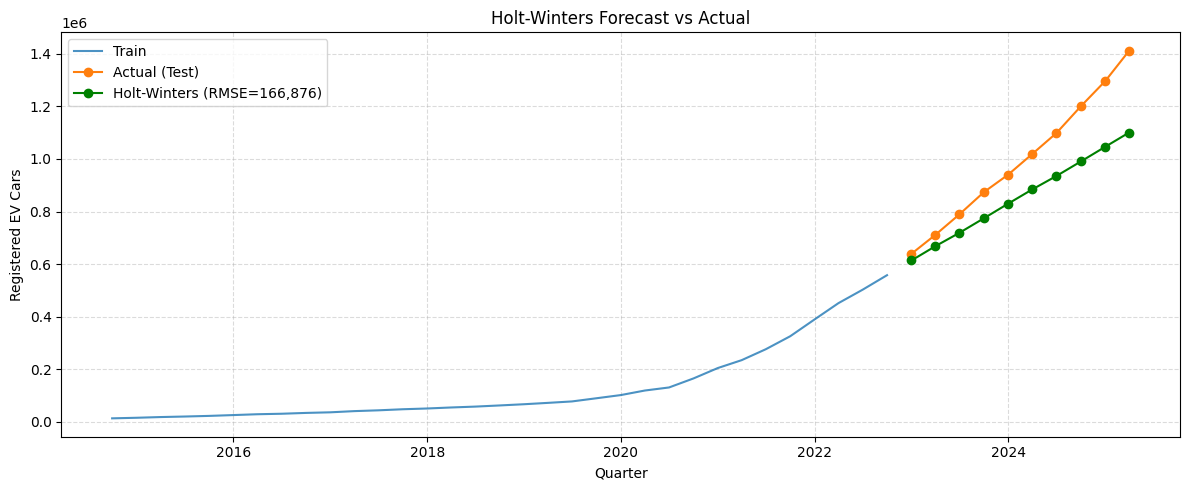

In [ ]:
# Plot train, actual test, and Holt-Winters forecast
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Registered_Cars'], label='Train', alpha=0.8)
plt.plot(test.index, test['Registered_Cars'], 'o-', label='Actual (Test)', color='#ff7f0e')
plt.plot(hw_series.index, hw_series, 'o-', label=f'Holt-Winters (RMSE={rmse_hw:,.0f})', color='green')
plt.title('Holt-Winters Forecast vs Actual')
plt.xlabel('Quarter'); plt.ylabel('Registered EV Cars')
plt.grid(True, linestyle='--', alpha=0.45)
plt.legend(); plt.tight_layout();
plt.show()

# Save predictions
hw_series.to_csv('holt_winters_forecast.csv', header=['HW_Forecast'])

In [ ]:
mape_hw = mean_absolute_percentage_error(test['Registered_Cars'], hw_series) * 100
accuracy_hw = 100 - mape_hw
print(f"Holt-Winters Accuracy: {accuracy_hw:.2f}%")

Holt-Winters Accuracy: 87.09%


In [ ]:
seasonal_periods = 4
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']

best_score = np.inf
best_cfg = None
best_forecast = None

for trend in trend_options:
    for seasonal in seasonal_options:
        # build model with chosen trend, seasonal
        model = ExponentialSmoothing(
            train['Registered_Cars'],
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods,
            initialization_method='estimated'
        )
        # fit model
        fitted = model.fit(optimized=True)
        # forecast test horizon
        preds = fitted.forecast(steps=len(test))
        preds = pd.Series(preds, index=test.index)
        # compute RMSE
        rmse_hw = np.sqrt(mean_squared_error(test['Registered_Cars'], preds))
        mape_hw = mean_absolute_percentage_error(test['Registered_Cars'], preds) * 100
        accuracy_hw = 100 - mape_hw

        print(f"trend={trend}, seasonal={seasonal}  RMSE={rmse_hw:,.0f} ACCURACY={accuracy_hw:.2f} %")
        # keep best
        if rmse_hw < best_score and accuracy_hw < 90 :
            best_score = rmse_hw
            best_cfg = (trend, seasonal)
            best_forecast = preds.copy()

# summary of best model
print("\nBest Holt-Winters config:", best_cfg)
print(f"Best Holt-Winters RMSE: {best_score:,.0f}")

trend=None, seasonal=None  RMSE=502,796 ACCURACY=59.38 %
trend=None, seasonal=add  RMSE=503,912 ACCURACY=59.23 %
trend=None, seasonal=mul  RMSE=519,256 ACCURACY=57.33 %
trend=add, seasonal=None  RMSE=161,884 ACCURACY=87.47 %
trend=add, seasonal=add  RMSE=166,876 ACCURACY=87.09 %
trend=add, seasonal=mul  RMSE=148,861 ACCURACY=88.77 %
trend=mul, seasonal=None  RMSE=86,644 ACCURACY=94.54 %
trend=mul, seasonal=add  RMSE=79,547 ACCURACY=94.94 %
trend=mul, seasonal=mul  RMSE=210,148 ACCURACY=87.53 %

Best Holt-Winters config: ('add', 'mul')
Best Holt-Winters RMSE: 148,861


In [ ]:
# Fit Holt-Winters on training data
hw_model = ExponentialSmoothing(
    train['Registered_Cars'],
    trend='add',
    seasonal='mul',
    seasonal_periods=4,
    initialization_method='estimated'
).fit(optimized=True)

# Forecast same horizon as test
hw_forecast = hw_model.forecast(steps=len(test))

# Evaluate with RMSE
rmse_hw = np.sqrt(mean_squared_error(test['Registered_Cars'], hw_forecast))
print(f"Holt-Winters RMSE: {rmse_hw:,.2f}")

# Convert forecast to Series for plotting and saving
hw_series = pd.Series(hw_forecast.values, index=test.index, name='HW_Pred')

Holt-Winters RMSE: 148,860.93


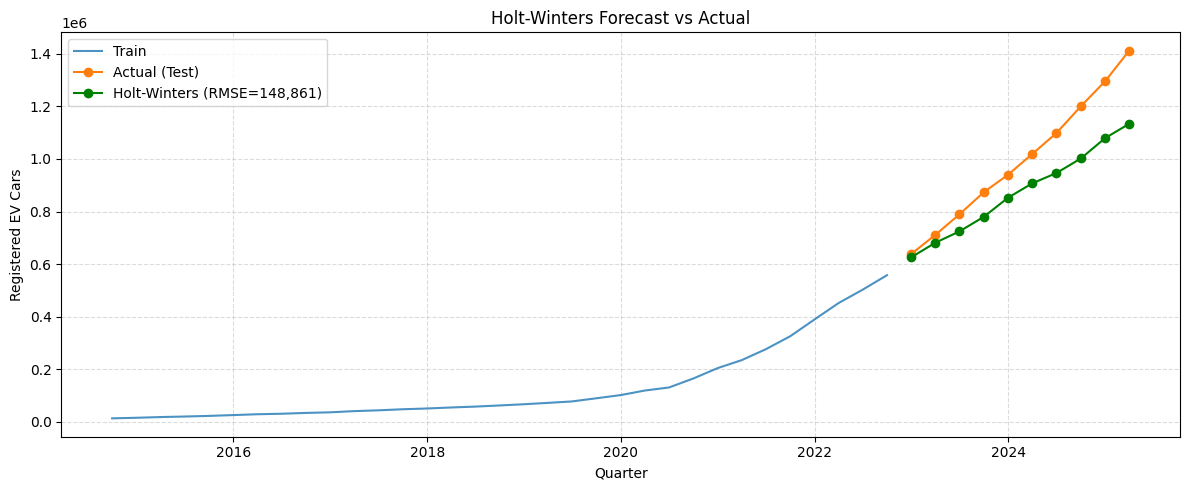

In [ ]:
# Plot train, actual test, and Holt-Winters forecast
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Registered_Cars'], label='Train', alpha=0.8)
plt.plot(test.index, test['Registered_Cars'], 'o-', label='Actual (Test)', color='#ff7f0e')
plt.plot(hw_series.index, hw_series, 'o-', label=f'Holt-Winters (RMSE={rmse_hw:,.0f})', color='green')
plt.title('Holt-Winters Forecast vs Actual')
plt.xlabel('Quarter'); plt.ylabel('Registered EV Cars')
plt.grid(True, linestyle='--', alpha=0.45)
plt.legend(); plt.tight_layout();
plt.show()

# Save predictions
hw_series.to_csv('holt_winters_forecast.csv', header=['HW_Forecast'])

In [ ]:
mape_hw = mean_absolute_percentage_error(test['Registered_Cars'], hw_forecast) * 100
accuracy_hw = 100 - mape_hw
print(f"Holt-Winters Accuracy: {accuracy_hw:.2f}%")

Holt-Winters Accuracy: 88.77%


#**LSTM**

In [ ]:
# scale training values
scaler = MinMaxScaler()
train_values = train['Registered_Cars'].values.reshape(-1, 1)
scaler.fit(train_values)

# scale the full series for sequence creation
full_values = trend_data['Registered_Cars'].values.reshape(-1,1)
scaled_full = scaler.transform(full_values)

In [ ]:
# create input sequences (X) and targets (y)
# look_back = number of past quarters used to predict next quarter
LOOK_BACK = 2

def create_sequences(arr, look_back):
    X, y = [], []
    for i in range(len(arr) - look_back):
        X.append(arr[i:i+look_back, 0])
        y.append(arr[i+look_back, 0])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(scaled_full, LOOK_BACK)

# split by using the same test length
n_test = len(test)
X_train = X_all[:-n_test]
y_train = y_all[:-n_test]
X_test  = X_all[-n_test:]
y_test  = y_all[-n_test:]


In [ ]:
# reshape to (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], LOOK_BACK, 1))
X_test  = X_test.reshape((X_test.shape[0], LOOK_BACK, 1))

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (31, 2, 1)
Testing shape: (10, 2, 1)


In [ ]:
# simple LSTM model (default settings)
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(LOOK_BACK, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 150
BATCH = 16

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=0.08,
    verbose=1
)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0602 - val_loss: 0.7361
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0426 - val_loss: 0.6797
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0355 - val_loss: 0.6259
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0413 - val_loss: 0.5726
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0246 - val_loss: 0.5235
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0298 - val_loss: 0.4747
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0238 - val_loss: 0.4287
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0189 - val_loss: 0.3850
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0214 - val_loss: 0.3438
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0193 - val_loss: 0.3060
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0217 - val_loss: 0.2733
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0198 - val_l

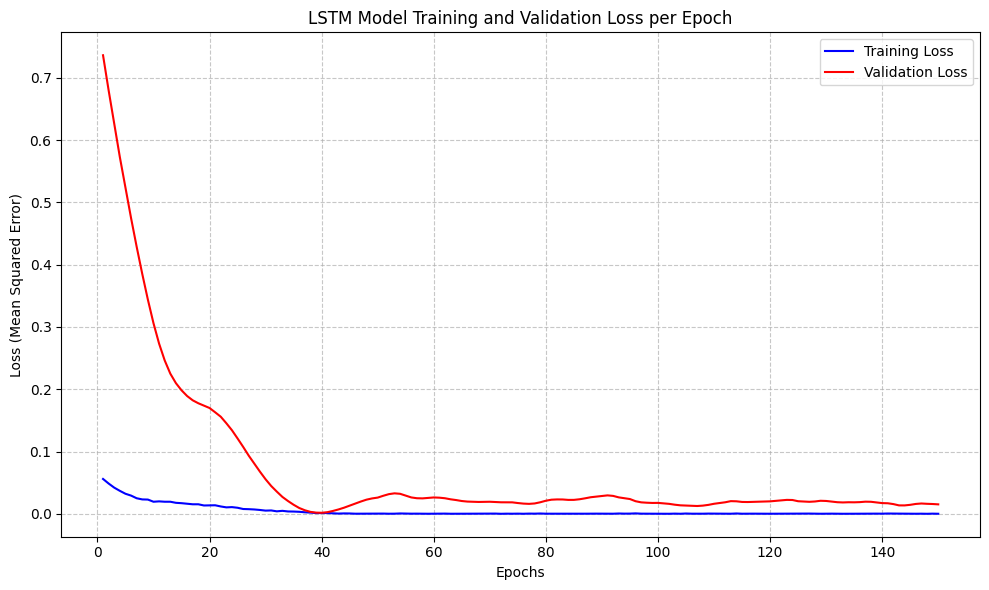

In [ ]:
# Get training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'red', label='Validation Loss')

# Add title and labels for clarity
plt.title('LSTM Model Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend() # Display the legend to identify the lines
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# predict for test period
y_pred_scaled = model.predict(X_test)

# convert back to original scale
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# create a series with proper index
lstm_pred = pd.Series(y_pred, index=test.index, name='LSTM_Pred')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


LSTM RMSE: 324,283.94


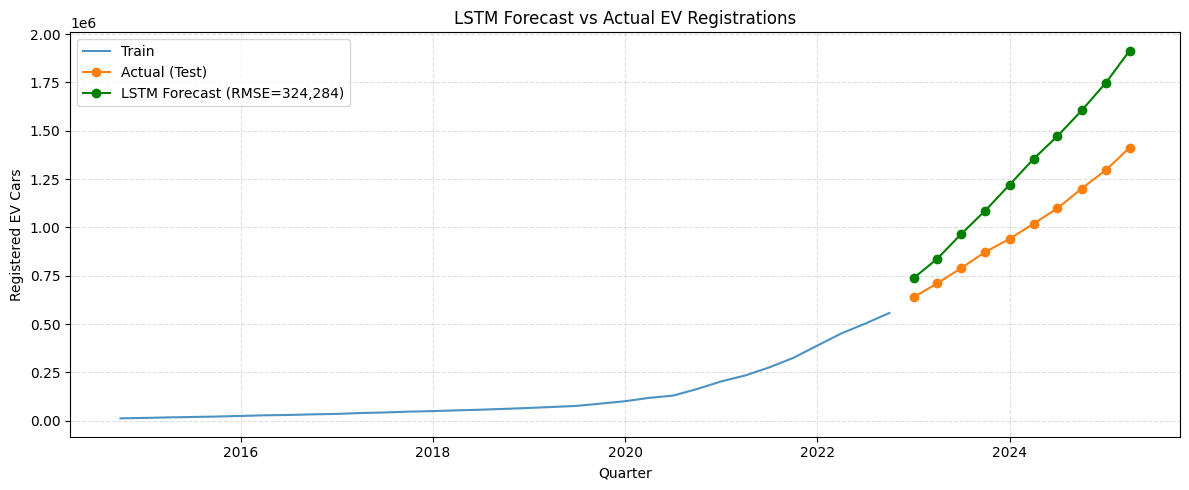

In [ ]:
# calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(test['Registered_Cars'], lstm_pred))
print(f"LSTM RMSE: {rmse_lstm:,.2f}")

# plot train, test, and predictions
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Registered_Cars'], label='Train', alpha=0.8)
plt.plot(test.index, test['Registered_Cars'], 'o-', label='Actual (Test)', color='#ff7f0e')
plt.plot(lstm_pred.index, lstm_pred, 'o-', label=f'LSTM Forecast (RMSE={rmse_lstm:,.0f})', color='green')

plt.title("LSTM Forecast vs Actual EV Registrations")
plt.xlabel("Quarter")
plt.ylabel("Registered EV Cars")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mape_hw = mean_absolute_percentage_error(test['Registered_Cars'], lstm_pred) * 100
accuracy_hw = 100 - mape_hw
print(f"LSTM Accuracy: {accuracy_hw:.2f}%")

LSTM Accuracy: 71.93%


#**Prediction (2030)**

##**ARIMA**

In [ ]:
# combine train + test into full series
full_series = pd.concat([train['Registered_Cars'], test['Registered_Cars']])  # preserves index order
full_series = full_series.sort_index()
full_series.index = pd.to_datetime(full_series.index)
print(full_series.head(5))

Quarter_End
2014-09-30 23:59:59.999999999    12392
2014-12-31 23:59:59.999999999    14571
2015-03-31 23:59:59.999999999    17267
2015-06-30 23:59:59.999999999    19291
2015-09-30 23:59:59.999999999    21683
Name: Registered_Cars, dtype: int64


In [ ]:
order = (1, 1, 2)
arima_full = ARIMA(full_series, order=order).fit()

In [ ]:
last_q = full_series.index[-1].to_period('Q')
future_periods = pd.period_range(start=last_q + 1, end='2030Q4', freq='Q')
future_index = future_periods.to_timestamp(how='end')
steps = len(future_index)
print("Forecast quarters:", steps)

Forecast quarters: 23


In [ ]:
fc = arima_full.get_forecast(steps=steps)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

fc_mean.index = future_index
fc_ci.index = future_index

forecast_df = pd.DataFrame({
    'ARIMA_Forecast': fc_mean,
    'Lower_95': fc_ci.iloc[:,0],
    'Upper_95': fc_ci.iloc[:,1]
})
forecast_df.to_csv('arima_forecast_to_2030.csv')

final_val = forecast_df['ARIMA_Forecast'].iloc[-1]
print("Approx (millions):", f"{final_val/1_000_000:.2f} M")

Approx (millions): 4.01 M


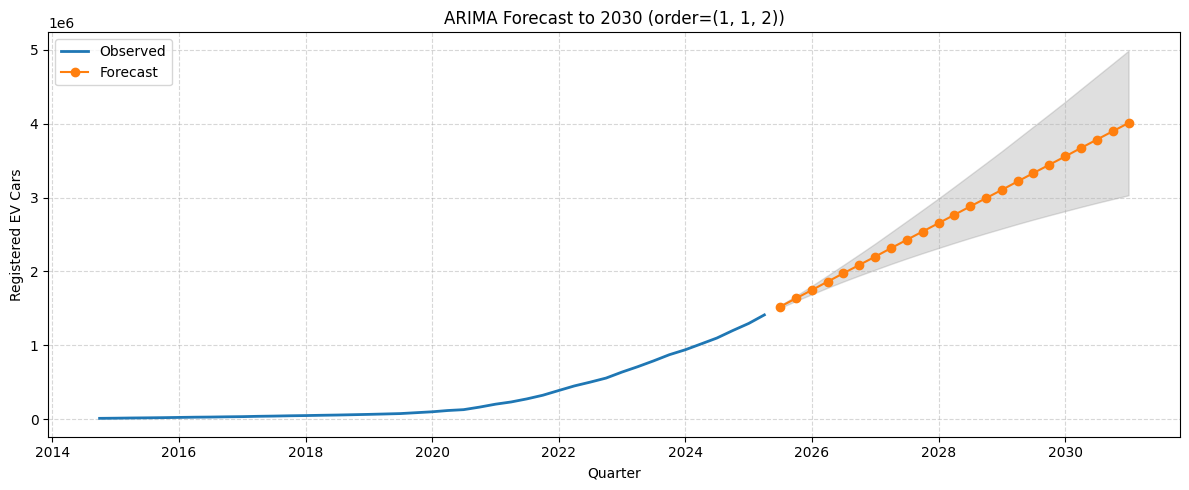

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(full_series.index, full_series, label='Observed', linewidth=2)
plt.plot(forecast_df.index, forecast_df['ARIMA_Forecast'], marker='o', label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower_95'], forecast_df['Upper_95'], color='gray', alpha=0.25)
plt.title(f'ARIMA Forecast to 2030 (order={order})')
plt.xlabel('Quarter'); plt.ylabel('Registered EV Cars')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

##**Holt-Winters**

In [ ]:
# use full EV time-series (train + test handled already in trend_data)
hw_series_full = trend_data['Registered_Cars'].sort_index()
hw_series_full.index = pd.to_datetime(hw_series_full.index)

In [ ]:
# fit Holt-Winters on the entire series for future forecasting
hw_full = ExponentialSmoothing(
    hw_series_full,
    trend='add',
    seasonal='mul',
    seasonal_periods=4,
    initialization_method='estimated'
).fit(optimized=True)

In [ ]:
# last observed quarter
last_q = hw_series_full.index[-1].to_period('Q')

# generate quarterly timestamps from next quarter to 2030Q4
future_periods = pd.period_range(start=last_q + 1, end='2030Q4', freq='Q')
future_index = future_periods.to_timestamp(how='end')

In [ ]:
# number of future quarters
steps = len(future_index)

# future forecast
hw_future = hw_full.forecast(steps=steps)

# assign proper datetime index
hw_future.index = future_index

final_val = hw_future.iloc[-1]
print("Approx (millions):", f"{final_val/1_000_000:.2f} M")

hw_future.to_csv("holt_winters_forecast_to_2030.csv", header=["HW_Forecast"])

Approx (millions): 3.93 M


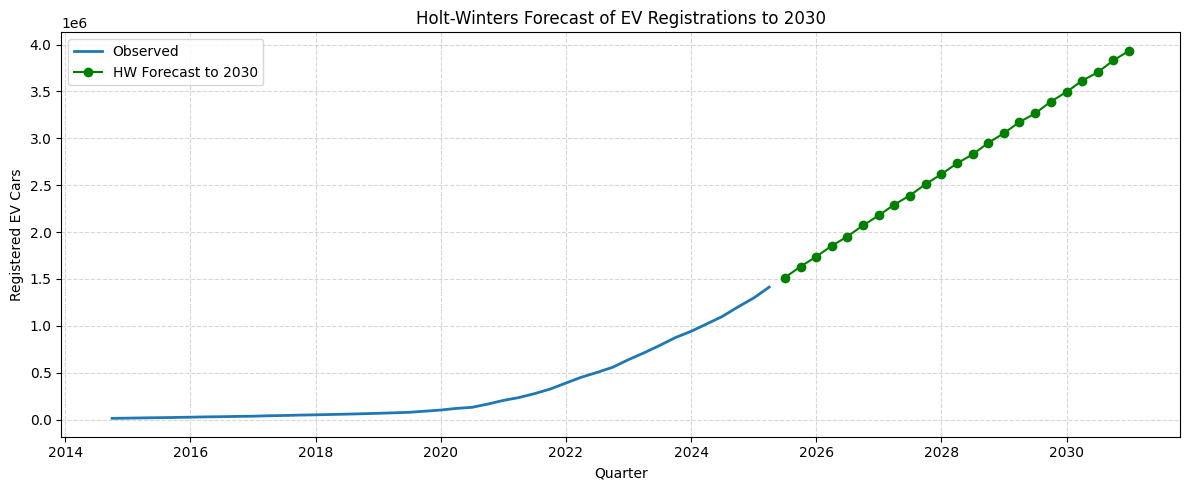

In [ ]:
plt.figure(figsize=(12,5))

# past data
plt.plot(hw_series_full.index, hw_series_full, label="Observed", linewidth=2)

# future forecast
plt.plot(hw_future.index, hw_future, marker='o', label="HW Forecast to 2030", color='green')

plt.title("Holt-Winters Forecast of EV Registrations to 2030")
plt.xlabel("Quarter")
plt.ylabel("Registered EV Cars")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

##**LSTM**

In [ ]:
# ensure scaled_full is a 2D numpy array (n,1)
scaled_full = scaled_full.reshape(-1, 1)

# choose a slightly larger window to capture seasonality
LOOK_BACK = 2

# create sequences from the full scaled series
def create_sequences_full(arr, look_back):
    X, y = [], []
    for i in range(len(arr) - look_back):
        X.append(arr[i:i+look_back, 0])
        y.append(arr[i+look_back, 0])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences_full(scaled_full, LOOK_BACK)

# reshape to LSTM format
X_all = X_all.reshape((X_all.shape[0], LOOK_BACK, 1))
print("Full sequence shapes:", X_all.shape, y_all.shape)


Full sequence shapes: (41, 2, 1) (41,)


In [ ]:
# build same simple model
model_full = Sequential([
    LSTM(128, activation='tanh', input_shape=(LOOK_BACK, 1)),
    Dropout(0.2),
    Dense(1)
])
model_full.compile(optimizer='adam', loss='mse')

# train
model_full.fit(
    X_all, y_all,
    epochs=150,
    batch_size=16,
    validation_split=0.08,
    verbose=1)


Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.4926 - val_loss: 4.5670
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4391 - val_loss: 4.1378
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4142 - val_loss: 3.7106
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3050 - val_loss: 3.3002
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2804 - val_loss: 2.8994
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2056 - val_loss: 2.5245
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1874 - val_loss: 2.1745
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1380 - val_loss: 1.8310
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1615 - val_loss: 1.4854
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1503 - val_loss: 1.1649
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1109 - val_loss: 0.8907
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0795 - val_l

In [ ]:
# prepare scalar history from full scaled series
scaled_history = [float(x) for x in scaled_full.reshape(-1)]

# forecast steps (ensure future_index already exists from earlier cell)
n_future = len(future_index)

preds = []
for _ in range(n_future):
    window = np.array(scaled_history[-LOOK_BACK:]).reshape(1, LOOK_BACK, 1)
    yhat_scaled = model_full.predict(window, verbose=0)
    yhat = scaler.inverse_transform(yhat_scaled.reshape(-1,1))[0,0]
    preds.append(yhat)
    scaled_history.append(float(yhat_scaled.flatten()[0]))


LSTM forecast for 2030 Q4: 2,071,300


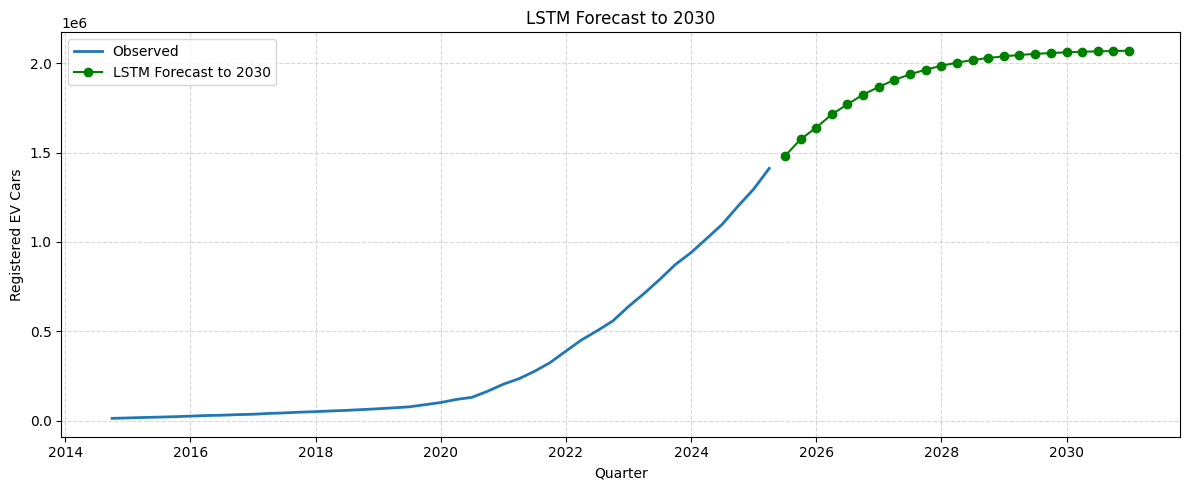

In [ ]:
# build Series and save
lstm_future = pd.Series(preds, index=future_index, name='LSTM_Forecast_2030')
lstm_future.to_csv("lstm_forecast_to_2030.csv", header=True)

# quick print last value
print("LSTM forecast for 2030 Q4:", f"{int(round(lstm_future.iloc[-1])):,}")

# plot observed + LSTM future
plt.figure(figsize=(12,5))
plt.plot(trend_data.index, trend_data['Registered_Cars'], label='Observed', linewidth=2)
plt.plot(lstm_future.index, lstm_future, marker='o', label='LSTM Forecast to 2030', color='green')
plt.title('LSTM Forecast to 2030')
plt.xlabel('Quarter'); plt.ylabel('Registered EV Cars')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# build a Series for the future forecast and save it
lstm_future = pd.Series(preds, index=future_index, name='LSTM_Forecast_2030_fullfit')
lstm_future.to_csv("lstm_forecast_to_2030_fullfit.csv", header=True)

# get the final predicted value for 2030 Q4
final_val = lstm_future.iloc[-1]

# print clean summary numbers
print("LSTM forecast for 2030 Q4:", f"{int(round(final_val)):,}")
print("Approx (millions):", f"{final_val/1_000_000:.2f} M")

LSTM forecast for 2030 Q4: 2,071,300
Approx (millions): 2.07 M
